### ***The First Approach for ECG Signal Analysis and Classification (feature extraction) :***

**Note that : To test the models with the test set you have ready in a file , just appload the file and change the name of the test file path in the final section of the test (the last cell) then run it to get the performance of the test**

## **Introduction**
Electrocardiogram (ECG) signals provide crucial information for diagnosing heart conditions. To extract meaningful features and accurately classify these signals, we follow a systematic approach that includes preprocessing, feature extraction, and machine learning model training. This document outlines the entire workflow, from data loading to model evaluation.

In [225]:
import pandas as pd

# Load ECG data
file_path = 'ECG200_TRAIN.txt'  # Update this with your actual file path
data = pd.read_csv(file_path, delim_whitespace=True, header=None)

# Extract labels and signals
labels = data.iloc[:, 0].values  # Extract labels (first column)
signals = data.iloc[:, 1:].values  # Extract ECG signals (remaining columns)

# Display the first few rows of the data
print(data.head())
print("Labels:", labels[:5])
print("Signals shape:", signals.shape)


    0         1         2         3         4         5         6         7   \
0 -1.0  0.502055  0.542163  0.722383  1.428885  2.136516  2.281149  1.936274   
1  1.0  0.147647  0.804668  0.367771  0.243894  0.026614 -0.274402  0.096731   
2 -1.0  0.316646  0.243199  0.370471  1.063738  1.678187  1.759558  1.697717   
3 -1.0  1.168874  2.075901  1.760141  1.606446  1.949046  1.302842  0.459332   
4  1.0  0.648658  0.752026  2.636231  3.455716  2.118157  0.520620 -0.188627   

         8         9   ...        87        88        89        90        91  \
0  1.468890  1.008845  ...  0.931043  0.610298  0.638894  0.684679  0.583238   
1 -0.747731 -1.609777  ... -0.533503 -0.400228  0.176084  1.111768  2.438428   
2  1.612159  1.168188  ...  0.764229  0.610621  0.552900  0.566786  0.604002   
3  0.516412  0.852180  ...  0.419006  0.723888  1.323947  2.136488  1.746597   
4  0.780818  0.933775  ... -0.097869 -0.136787 -0.340237 -0.089441 -0.080297   

         92        93        94       

### ECG Time Series Classification: Key Steps and Insights

This overview captures the essential steps and choices made in our ECG signal classification
project. We focused on preprocessing, feature extraction, and machine learning to accurately
classify heartbeats as normal or abnormal.
---
### Understanding the ECG Signal
ECG (Electrocardiogram) signals capture the heart’s electrical activity, characterized by the
following components:
- **P Wave**: Atrial depolarization.
- **QRS Complex**: Ventricular depolarization.
- **T Wave**: Ventricular repolarization.
Abnormalities in these waves can indicate conditions like arrhythmias or myocardial infarction.
---
### Data Preparation and Preprocessing
Our preprocessing steps aimed to clean and standardize the ECG data:
1. **Baseline Drift Removal**: Using wavelet transforms to eliminate low-frequency components.
2. **Low-Pass Filtering**: Removing high-frequency noise while preserving essential signal
components.
3. **Notch Filtering**: Eliminating powerline interference at 50/60 Hz.
4. **Normalization**: Scaling signals to a consistent range for better comparison and model
performance.
5. **R-Peak Alignment**: Centering the signals around the R peak for consistency in waveform
analysis because it is the standard to have it in the center .
These steps ensure that the signals are clean and comparable, critical for accurate feature
extraction and analysis.
---
### Feature Extraction
We extracted features that capture both the time-domain and frequency-domain characteristics
of the ECG signals:
- **Statistical Features**: Mean, standard deviation, skewness, and kurtosis to summarize the
signal’s basic properties.
- **Morphological Features**: Amplitudes and intervals of P, Q, R, S, and T peaks, reflecting the
heart’s electrical activity and timing.
- **Frequency-Domain Features**: Power spectrum analysis to understand the signal’s energy
distribution across frequencies (even though it is tailored to stationary data and ours is not ) .
- **Wavelet Features**: Energy in different frequency bands, capturing the signal’s
non-stationary characteristics.
- **Entropy-Based Features**: Shannon entropy and fractal dimension to measure the signal’s
complexity ( there is a whole study on the effect of entropy on the ecg classification ) .
- **STFT Features**: Time-varying frequency content for dynamic analysis of the signal.
These features are crucial for capturing the intricate details of the ECG signals, enabling
effective classification.
---
### Model Training and Evaluation
We trained and evaluated several machine learning models to classify the ECG signals:
- **Logistic Regression,Support Vector Machine (SVM),Random Forest,Gradient Boosting.
Each model was assessed based on its accuracy and other performance metrics to identify the
best performer for our classification task. And they all performed perfectly which is likely an
indicator of overfitting that would be further confirmed or denied by the test set .
### Conclusion
Our approach integrates detailed signal preprocessing and diverse feature extraction with
machine learning, effectively distinguishing between normal and abnormal heartbeats. This
robust framework is adaptable to various ECG datasets and holds potential for automated heart
condition diagnosis in clinical settings.

# **Workflow Overview**
**Data Preprocessing :**
Noise Removal,
Signal Normalization,
R-Peak Detection and Alignment .
**Feature Extraction :**
Morphological Features,
Statistical Features,
Frequency-Domain Features,
Wavelet Transform Features,
Short-Time Fourier Transform (STFT) Features.
**Model Training :**
Model Initialization and Training,
Performance Evaluation,
Model Testing,
Preprocessing and Feature Extraction on Test Data,
Model Testing and Performance Reporting.

# ***1. Data Preprocessing***

from the observation of the plots at the end of this section we realize that this preprocessing indeed filtered the data without losing the essential patterns of normal and abnormal signals ( since we see the same patterns before and after the preprocessing )

**1.1 Noise Removal**

In [226]:
from scipy.signal import butter, filtfilt, iirnotch
import pywt

def remove_baseline_drift(signal, wavelet='db4', level=9):
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    coeffs[0] = np.zeros_like(coeffs[0])
    return pywt.waverec(coeffs, wavelet)

def low_pass_filter(signal, cutoff_freq, fs, order=4):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff_freq / nyquist
    b, a = butter(order, normal_cutoff, btype='low')
    return filtfilt(b, a, signal)

def notch_filter(signal, fs, freq=50.0, quality_factor=30.0):
    b, a = iirnotch(freq, quality_factor, fs)
    return filtfilt(b, a, signal)


**1.2 Signal Normalization**

In [227]:
def normalize_signal(signal):
    min_val = np.min(signal)
    max_val = np.max(signal)
    return 2 * (signal - min_val) / (max_val - min_val) - 1


**1.3 R-Peak Detection and Alignment**

In [228]:
from scipy.signal import find_peaks
import numpy as np

def detect_r_peak(signal):
    peaks, _ = find_peaks(signal, distance=len(signal)//2, height=0.5)
    if len(peaks) > 0:
        return peaks[0]
    return None

def align_to_r_peak(signal, r_peak_index):
    length = len(signal)
    centered_signal = np.roll(signal, length // 2 - r_peak_index)
    return centered_signal


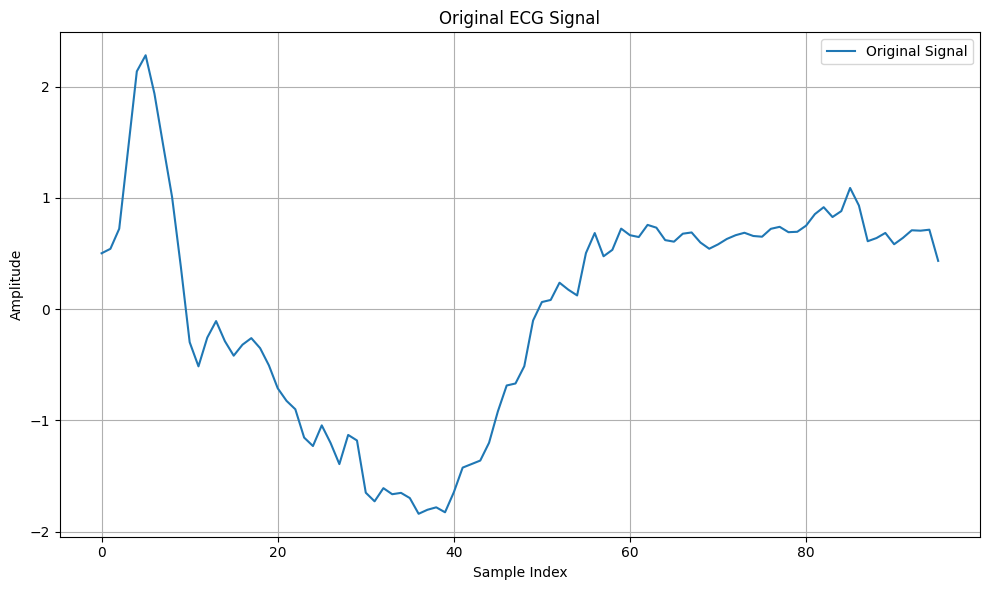

/usr/local/lib/python3.10/dist-packages/pywt/_multilevel.py:43: UserWarning: Level value of 9 is too high: all coefficients will experience boundary effects.
  warnings.warn(


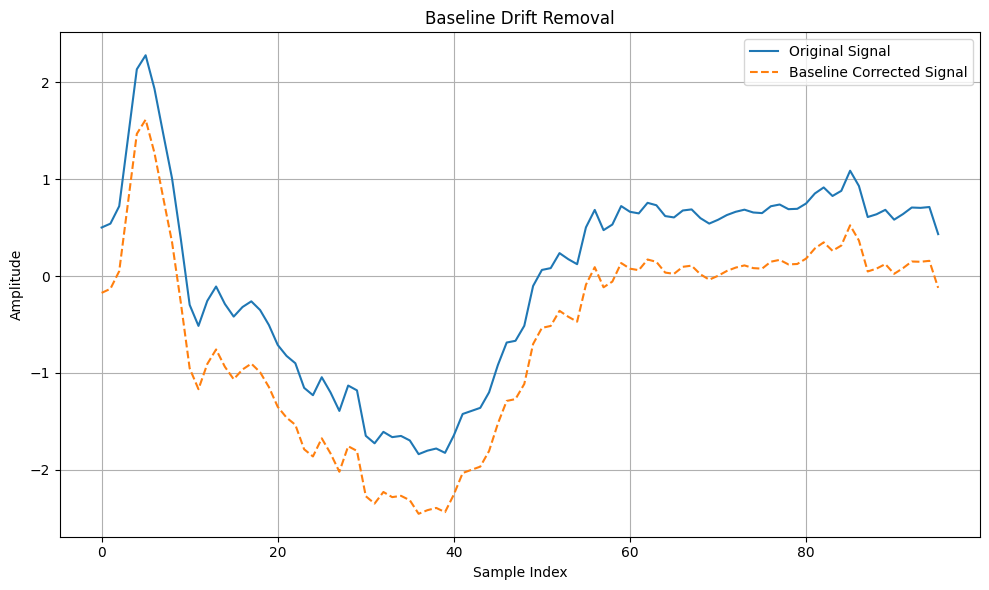

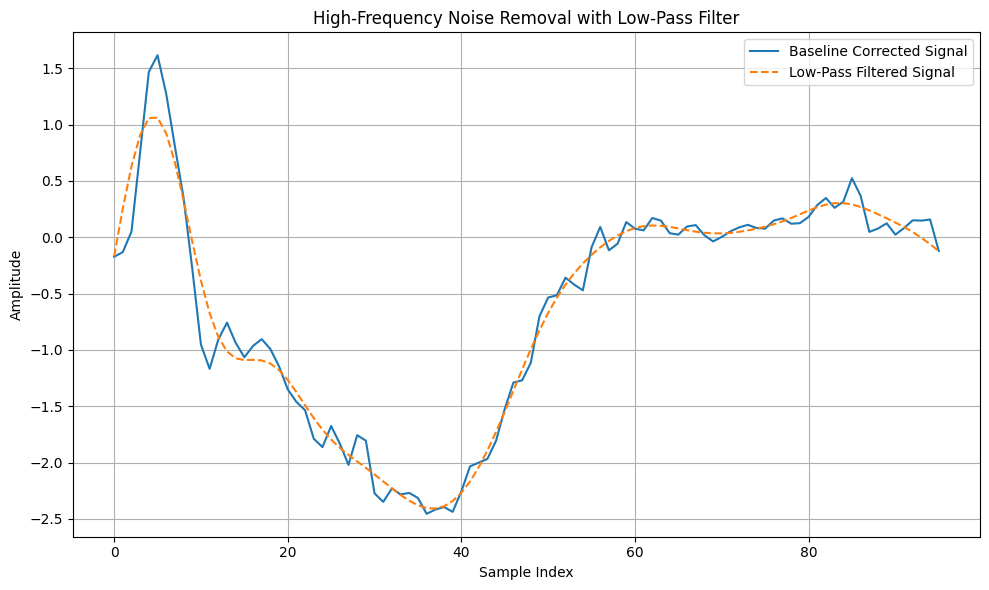

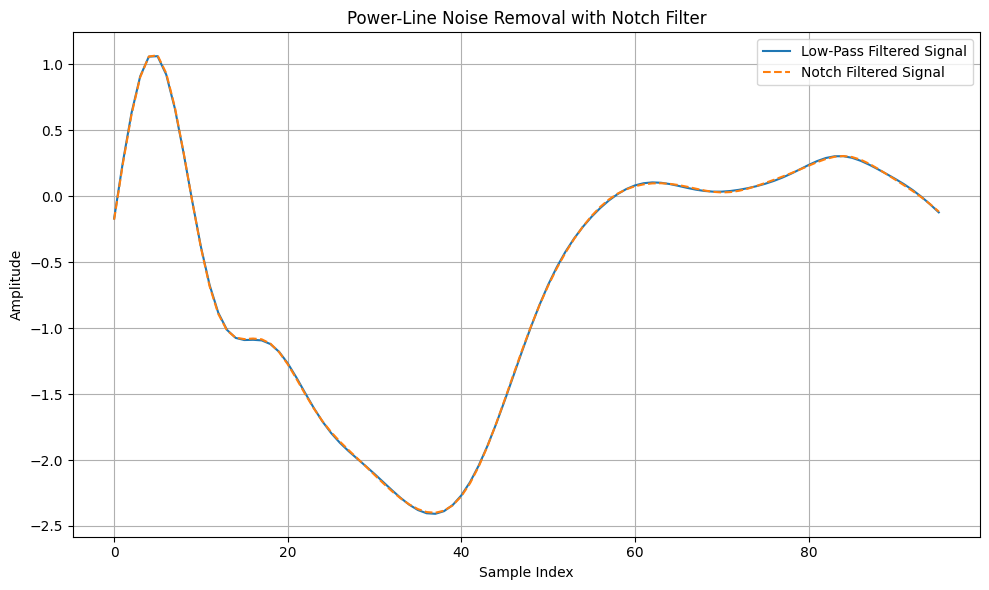

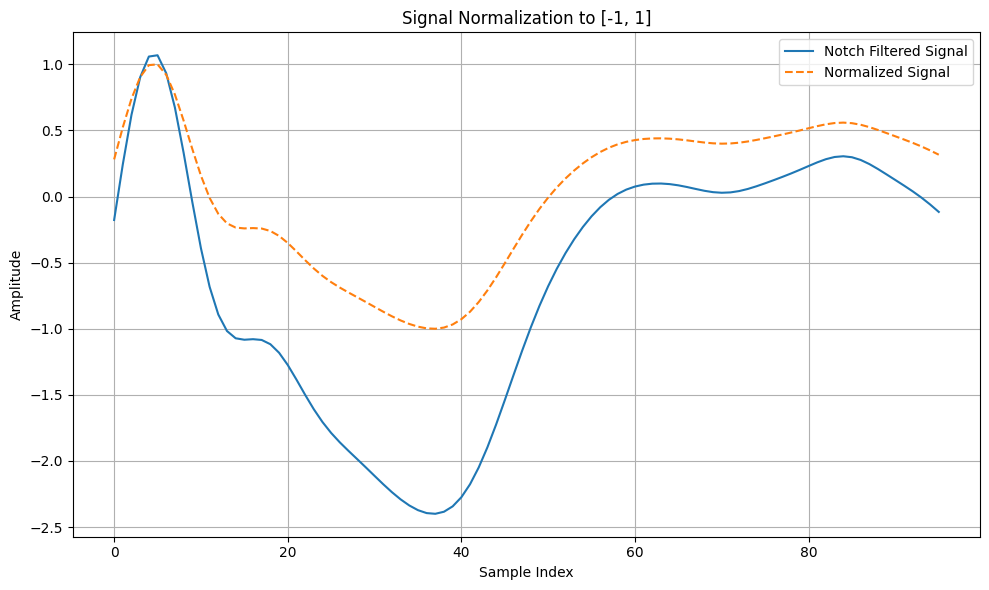

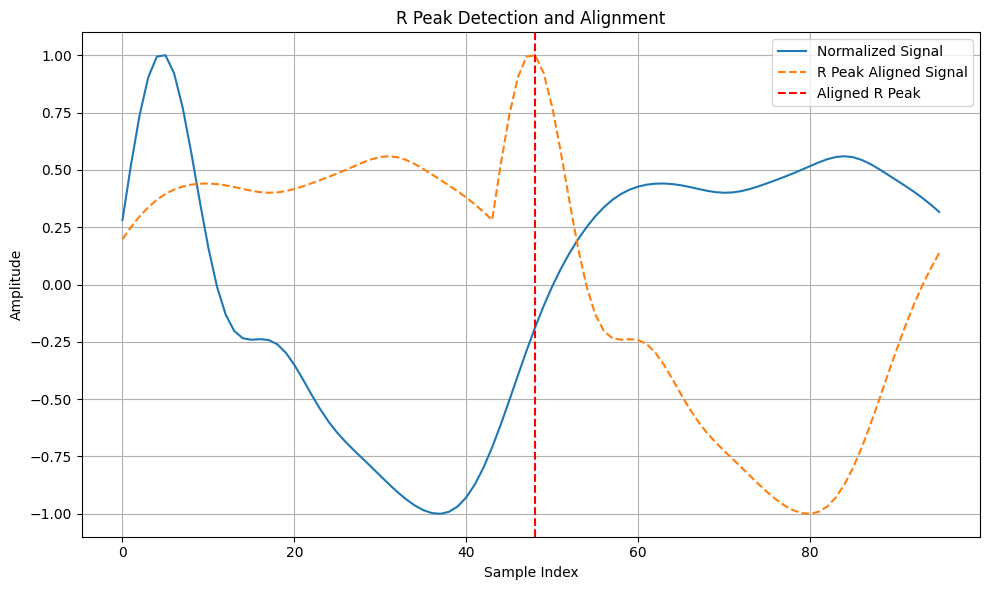

In [229]:
signal = signals[0]  # Select the first signal for demonstration

# Plot the original signal
plt.figure(figsize=(10, 6))
plt.plot(signal, label='Original Signal')
plt.title('Original ECG Signal')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Step 1: Remove baseline drift
signal_baseline_removed = remove_baseline_drift(signal)
plt.figure(figsize=(10, 6))
plt.plot(signal, label='Original Signal')
plt.plot(signal_baseline_removed, label='Baseline Corrected Signal', linestyle='--')
plt.title('Baseline Drift Removal')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Step 2: Apply low-pass filter
signal_low_pass = low_pass_filter(signal_baseline_removed, cutoff_freq=40, fs=fs)
plt.figure(figsize=(10, 6))
plt.plot(signal_baseline_removed, label='Baseline Corrected Signal')
plt.plot(signal_low_pass, label='Low-Pass Filtered Signal', linestyle='--')
plt.title('High-Frequency Noise Removal with Low-Pass Filter')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Step 3: Apply notch filter
signal_notch_filtered = notch_filter(signal_low_pass, fs=fs)
plt.figure(figsize=(10, 6))
plt.plot(signal_low_pass, label='Low-Pass Filtered Signal')
plt.plot(signal_notch_filtered, label='Notch Filtered Signal', linestyle='--')
plt.title('Power-Line Noise Removal with Notch Filter')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Step 4: Normalize the signal
signal_normalized = normalize_signal(signal_notch_filtered)
plt.figure(figsize=(10, 6))
plt.plot(signal_notch_filtered, label='Notch Filtered Signal')
plt.plot(signal_normalized, label='Normalized Signal', linestyle='--')
plt.title('Signal Normalization to [-1, 1]')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Step 5: Detect and align to the R peak
r_peak_index = detect_r_peak(signal_normalized)
if r_peak_index is not None:
    signal_aligned = align_to_r_peak(signal_normalized, r_peak_index)
    plt.figure(figsize=(10, 6))
    plt.plot(signal_normalized, label='Normalized Signal')
    plt.plot(signal_aligned, label='R Peak Aligned Signal', linestyle='--')
    plt.axvline(len(signal) // 2, color='red', linestyle='--', label='Aligned R Peak')
    plt.title('R Peak Detection and Alignment')
    plt.xlabel('Sample Index')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("R peak not detected in the signal.")

In [230]:
# Define the sampling frequency for the ECG data
fs = 500  # Example frequency, adjust based on your dataset

# Apply preprocessing to the signals
processed_signals = []
normalized_signals = []
for signal in signals:
    # Step 1: Remove baseline drift
    signal_processed = remove_baseline_drift(signal)

    # Step 2: Apply low-pass filter
    signal_processed = low_pass_filter(signal_processed, cutoff_freq=40, fs=fs)

    # Step 3: Apply notch filter
    signal_processed = notch_filter(signal_processed, fs=fs)

    # Step 4: Normalize the signal
    normalized_signal = normalize_signal(signal_processed)

    # Step 5: Detect R peak
    r_peak_index = detect_r_peak(normalized_signal)

    # Step 6: Align the signal to the R peak if detected
    if r_peak_index is not None:
        aligned_signal = align_to_r_peak(normalized_signal, r_peak_index)
    else:
        # If no R peak is detected, use the normalized signal as is
        aligned_signal = normalized_signal

    # Add the processed (and aligned) signal to the list
    processed_signals.append(aligned_signal)
    normalized_signals.append(normalized_signal)

# Convert processed signals to a numpy array
processed_signals = np.array(processed_signals)

normalized_signals = np.array(normalized_signals)

# Display the shape of the processed signals array for validation
print("Processed signals shape:", processed_signals.shape)


Processed signals shape: (100, 96)


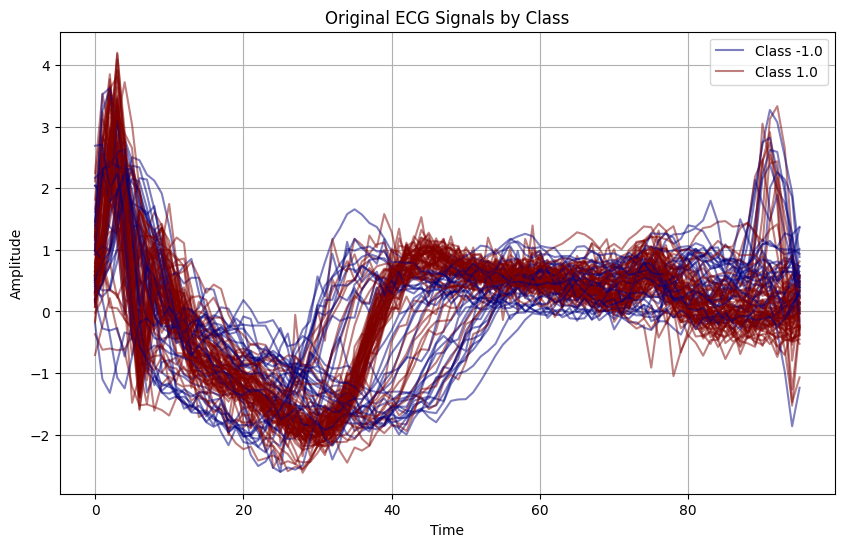

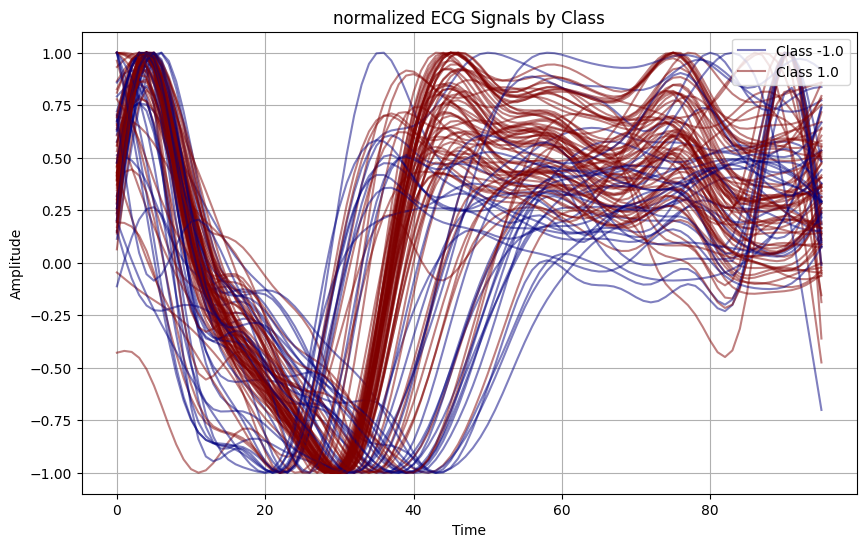

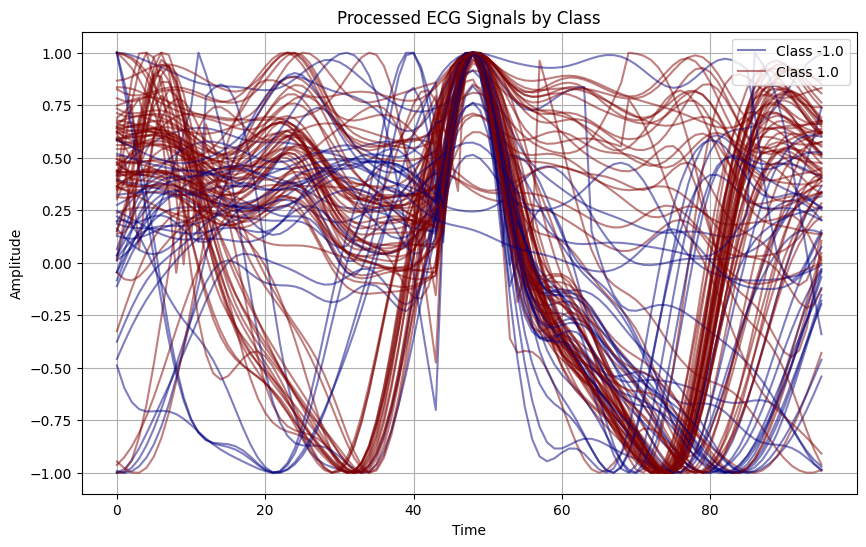

In [231]:

# Function to plot all instances with different colors for different classes
def plot_signals(signals, labels, title):
    unique_labels = np.unique(labels)
    colors = plt.cm.jet(np.linspace(0, 1, len(unique_labels)))

    plt.figure(figsize=(10, 6))
    plotted_labels = set()  # To keep track of labels already plotted

    for i, signal in enumerate(signals):
        label = labels[i]
        color = colors[np.where(unique_labels == label)[0][0]]
        if label not in plotted_labels:
            plt.plot(signal, color=color, alpha=0.5, label=f'Class {label}')
            plotted_labels.add(label)
        else:
            plt.plot(signal, color=color, alpha=0.5)

    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()

# Plot original signals
plot_signals(signals, labels, 'Original ECG Signals by Class')


# Plot normalized signals
plot_signals(normalized_signals, labels, 'normalized ECG Signals by Class')

# Plot processed signals
plot_signals(processed_signals, labels, 'Processed ECG Signals by Class')

# **2. Feature Extraction**

In [232]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, iirnotch, stft, find_peaks
import pywt
from scipy.stats import entropy
from sklearn.preprocessing import StandardScaler  # Import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score
import seaborn as sns

**2.1 Morphological Features**

here we extract information about the heart beat cycle and we try to distinguish the different phases and their characteristics in our signals so we can use this information later

In [233]:
# Function to extract QRS features and detect peaks
def extract_qrs_features(signal, fs=500):
    r_peaks, _ = find_peaks(signal, distance=fs*0.6, height=0.5)
    if len(r_peaks) == 0:
        return [np.nan] * 10, {}

    r_peak = r_peaks[0]
    q_peak = np.argmin(signal[:r_peak]) if r_peak > 0 else 0
    s_peak = np.argmin(signal[r_peak:]) + r_peak if r_peak < len(signal) else r_peak
    t_peak = np.argmax(signal[s_peak:]) + s_peak if s_peak < len(signal) else s_peak
    p_peak = np.argmax(signal[:q_peak]) if q_peak > 0 else 0

    q_amplitude = signal[q_peak]
    r_amplitude = signal[r_peak]
    s_amplitude = signal[s_peak]
    t_amplitude = signal[t_peak]
    p_amplitude = signal[p_peak]

    pq_interval = (q_peak - p_peak) / fs * 1000  # Convert to milliseconds
    qr_interval = (r_peak - q_peak) / fs * 1000
    rs_interval = (s_peak - r_peak) / fs * 1000
    st_interval = (t_peak - s_peak) / fs * 1000
    tp_interval = (p_peak - t_peak) / fs * 1000 if t_peak > p_peak else np.nan

    peaks = {
        'P': p_peak,
        'Q': q_peak,
        'R': r_peak,
        'S': s_peak,
        'T': t_peak
    }

    return [q_amplitude, r_amplitude, s_amplitude, t_amplitude, p_amplitude,
            pq_interval, qr_interval, rs_interval, st_interval, tp_interval], peaks

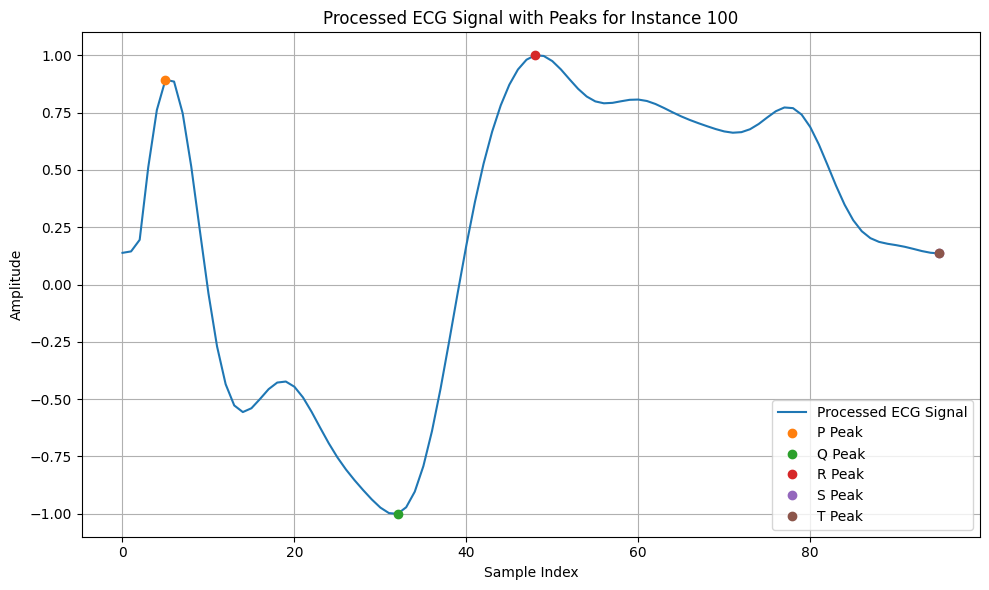

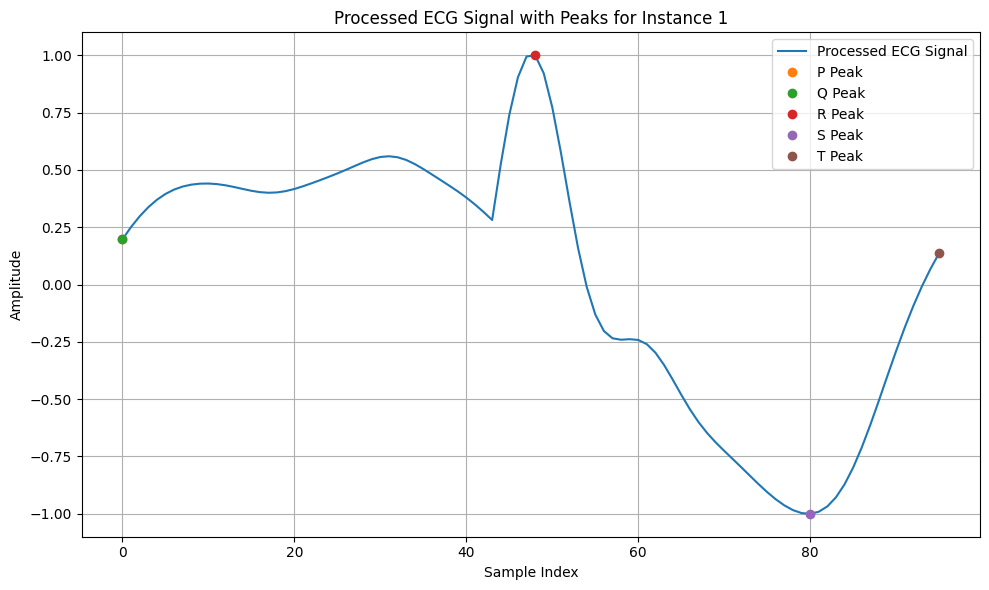

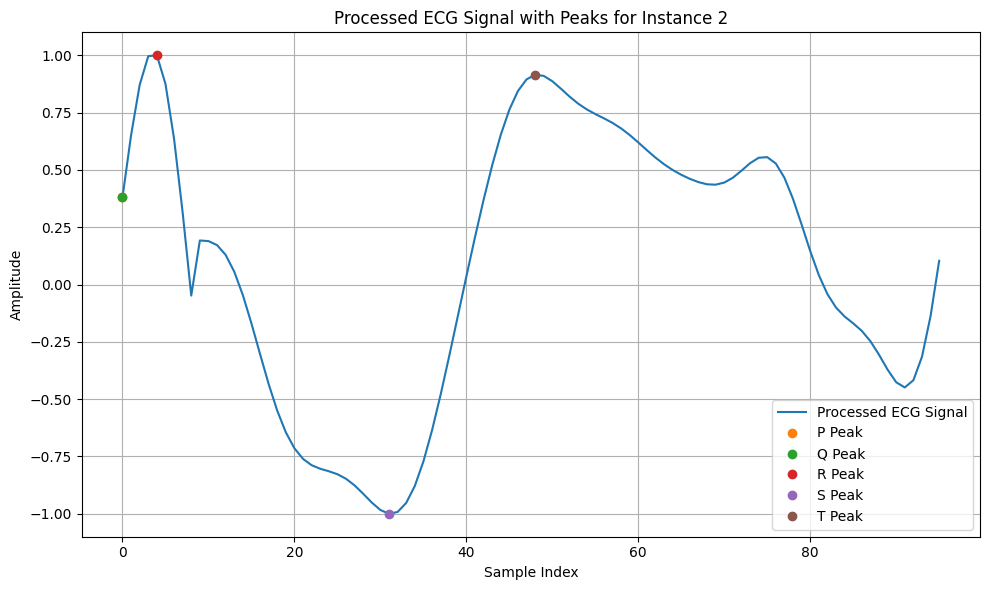

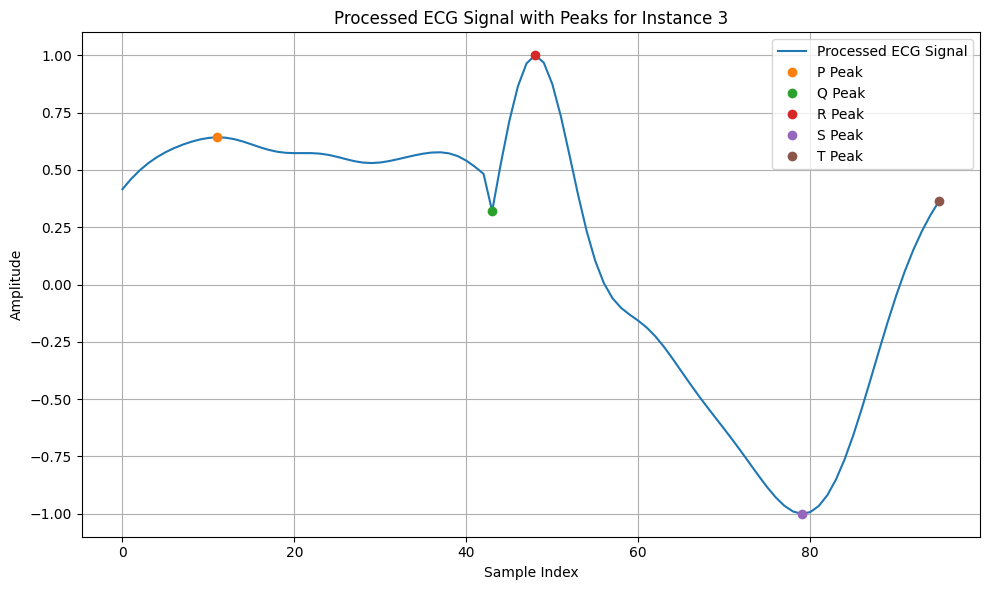

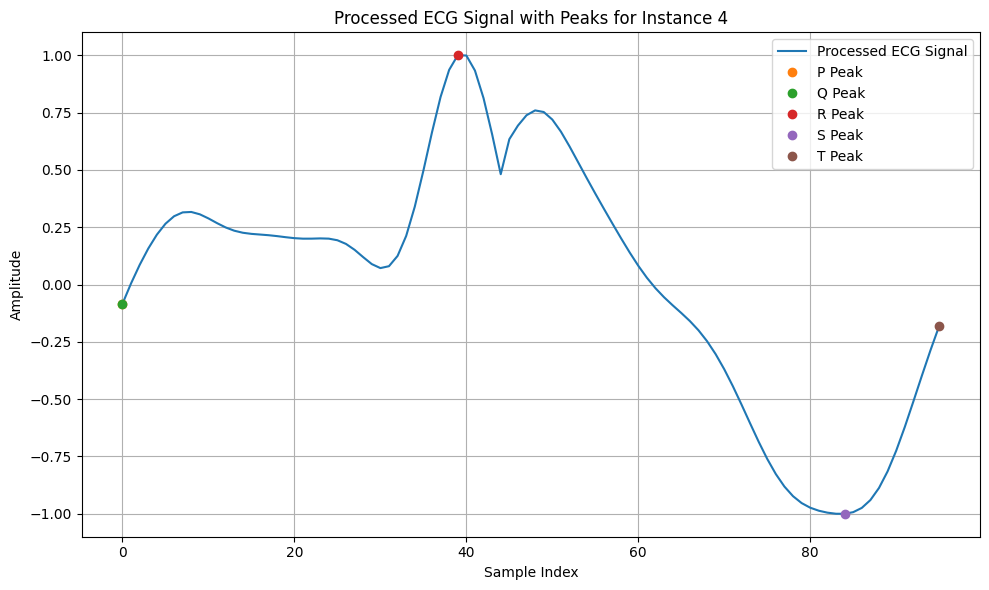

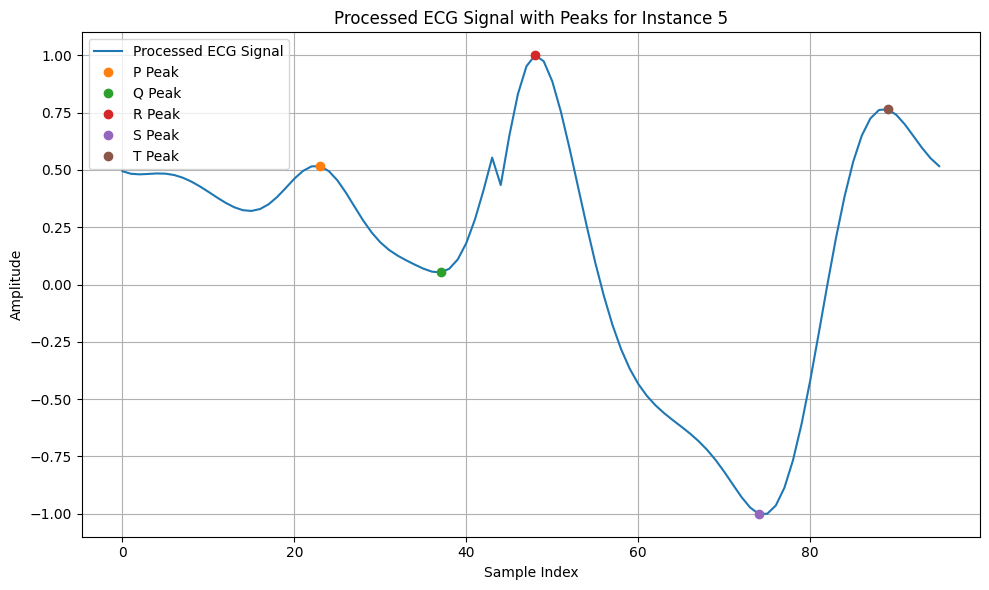

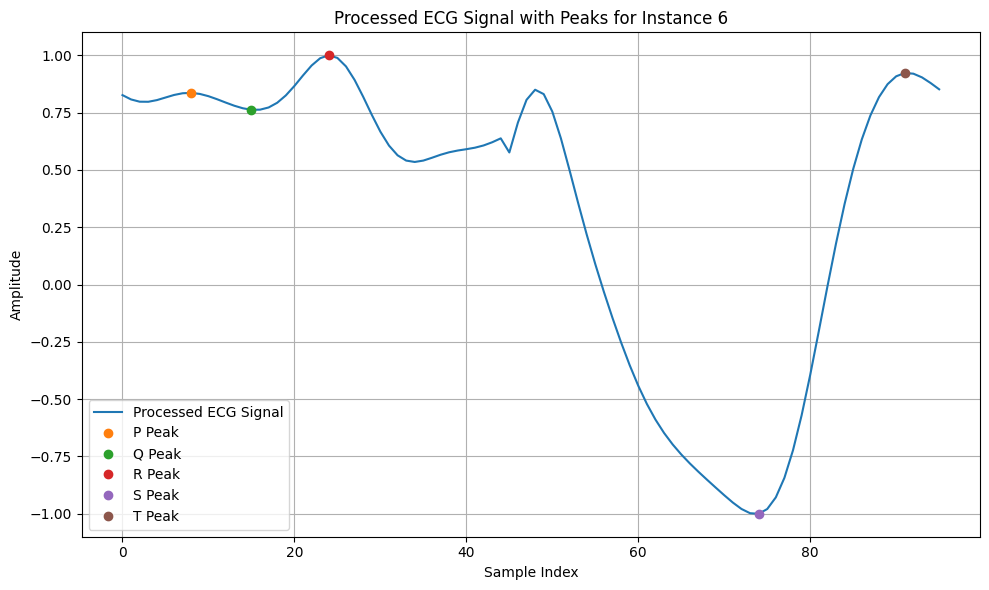

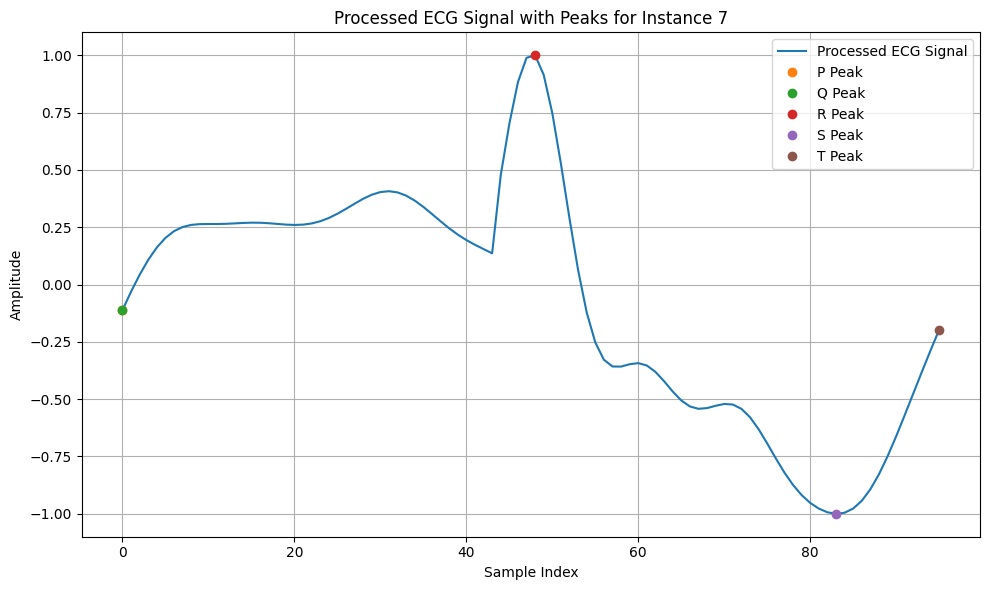

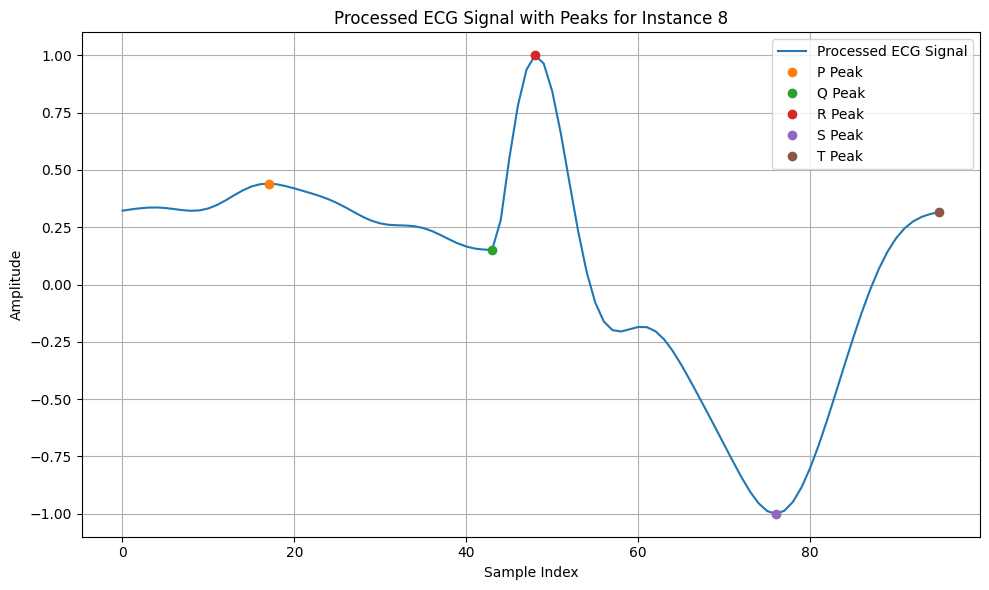

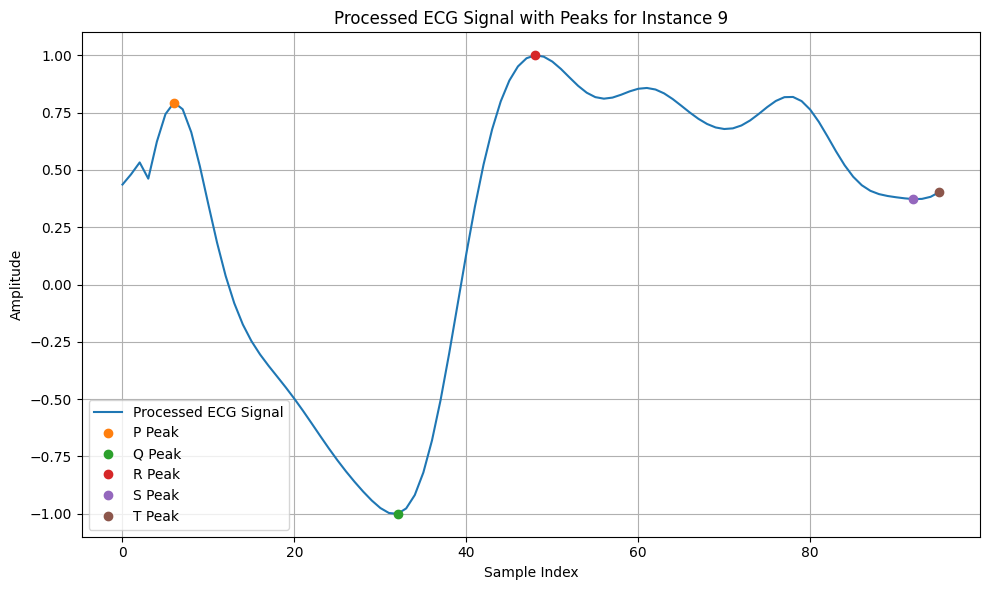

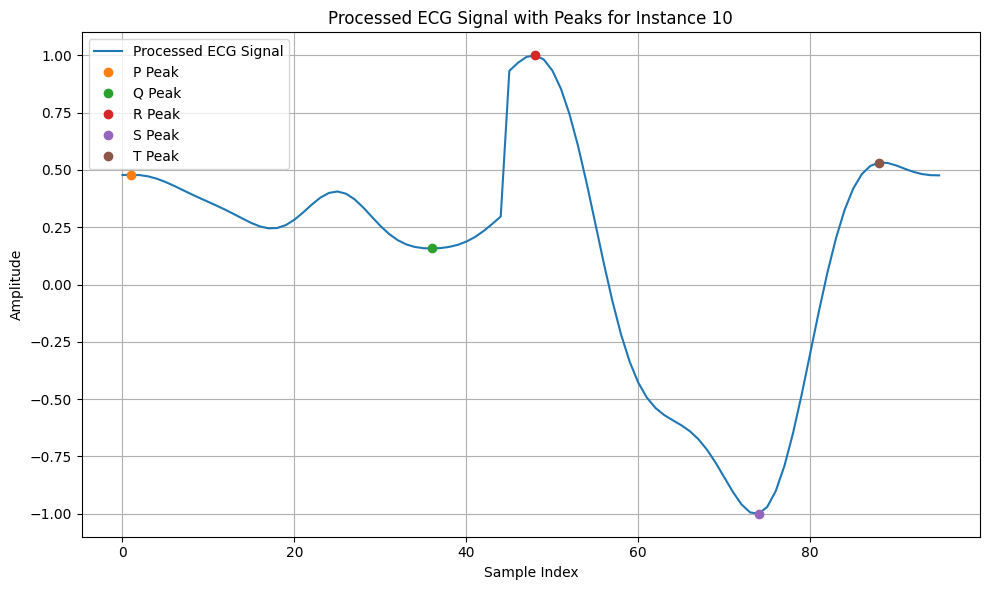

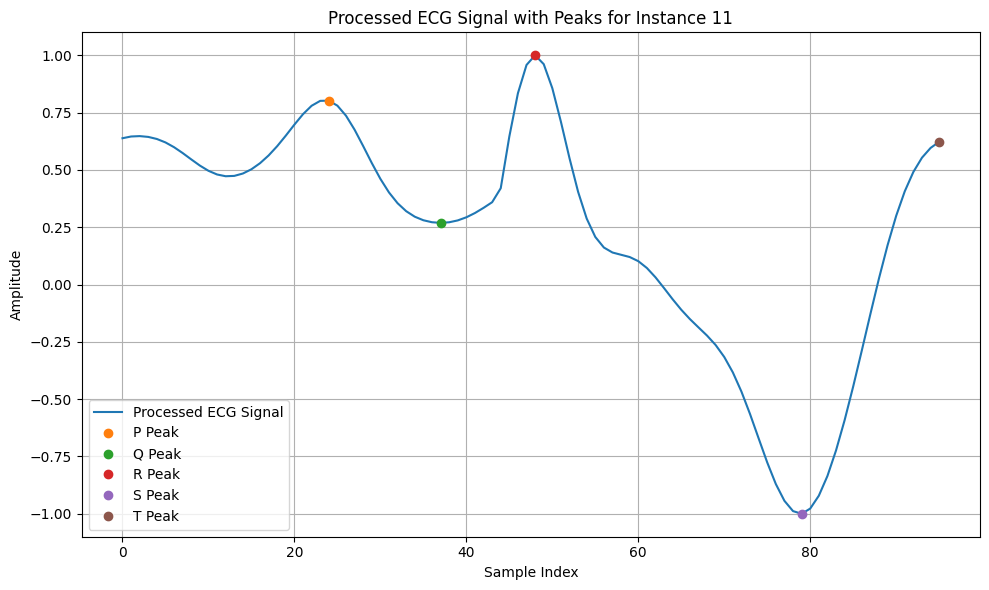

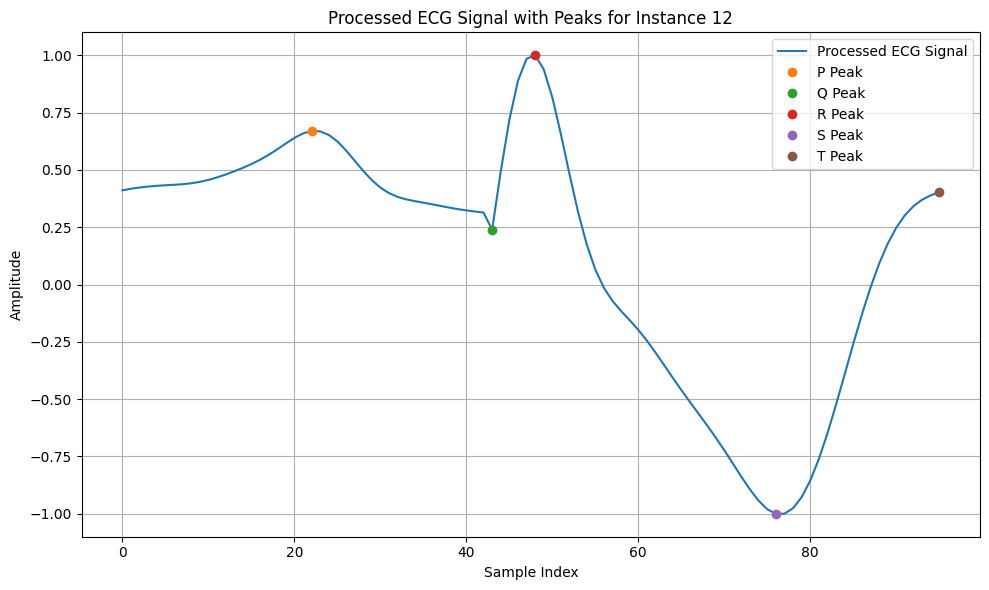

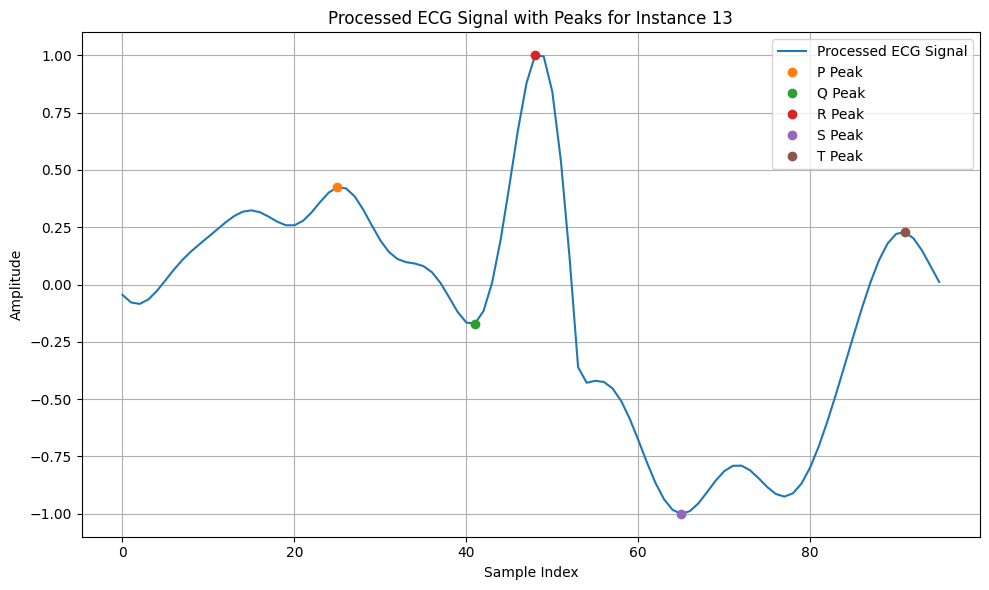

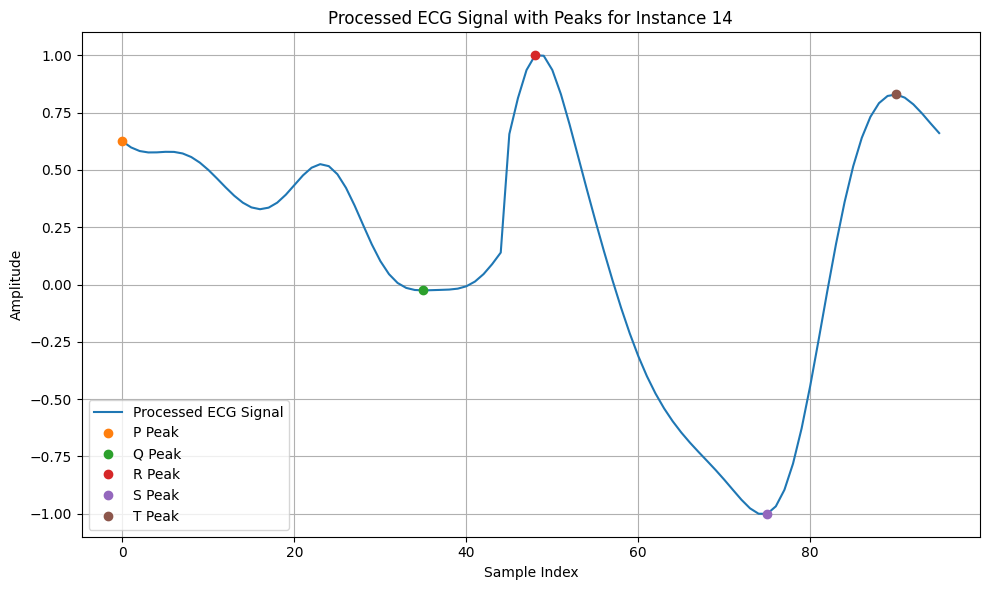

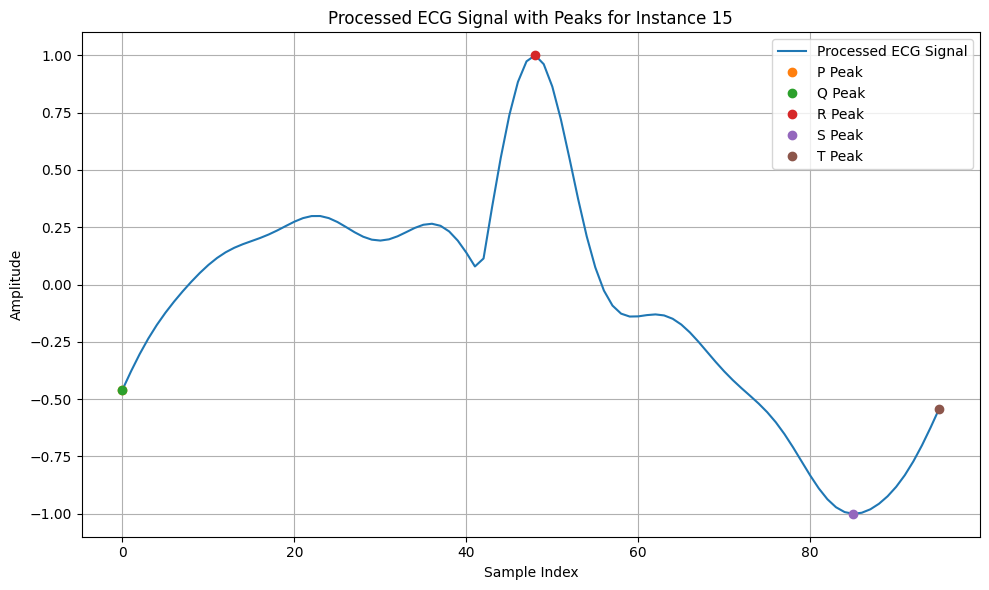

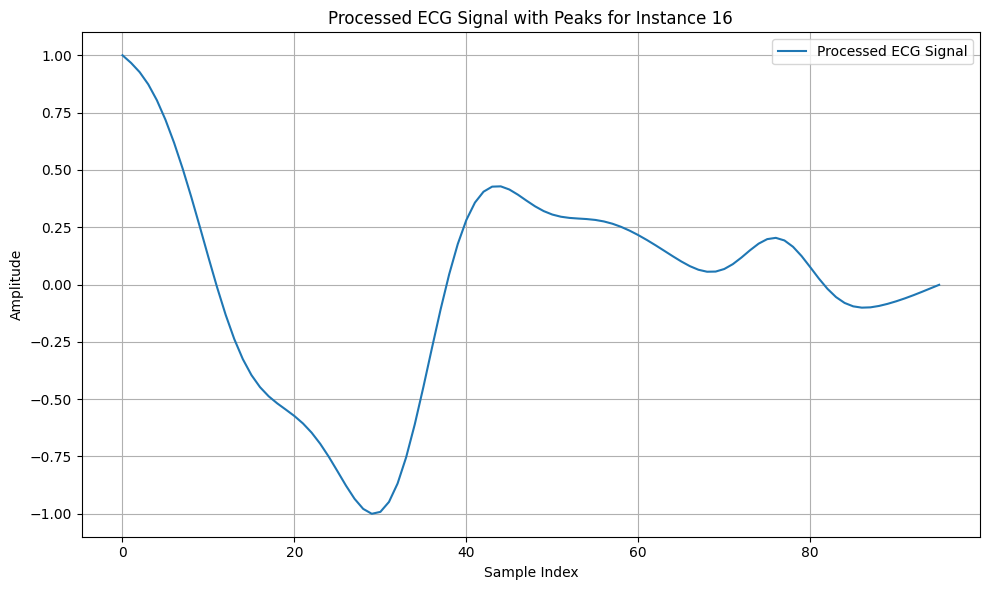

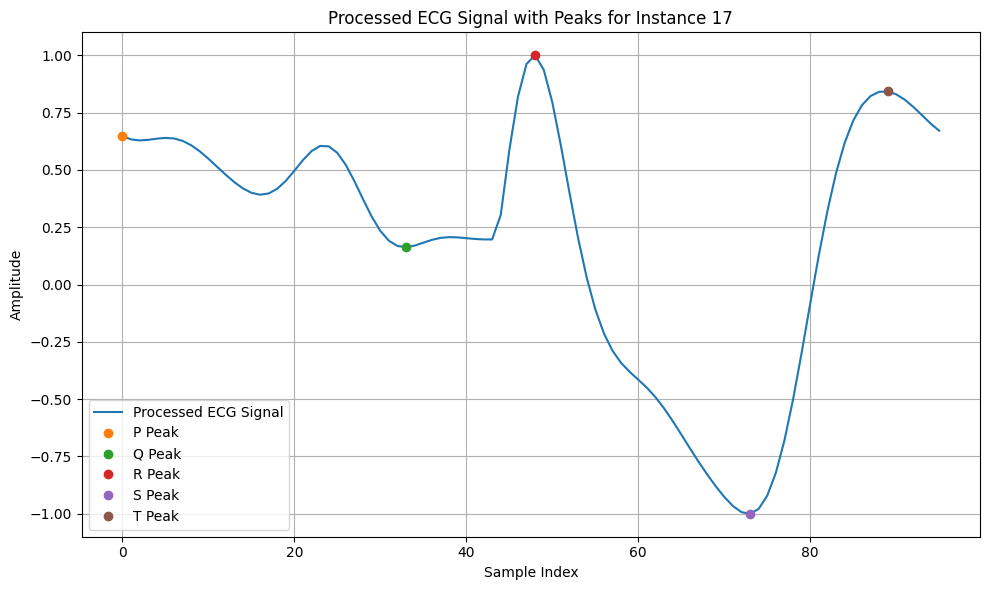

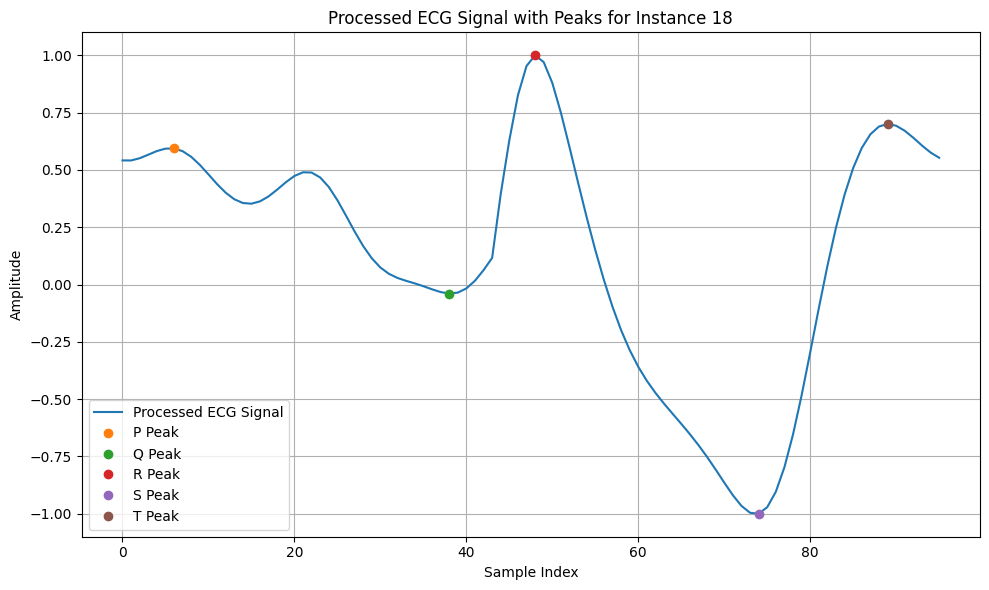

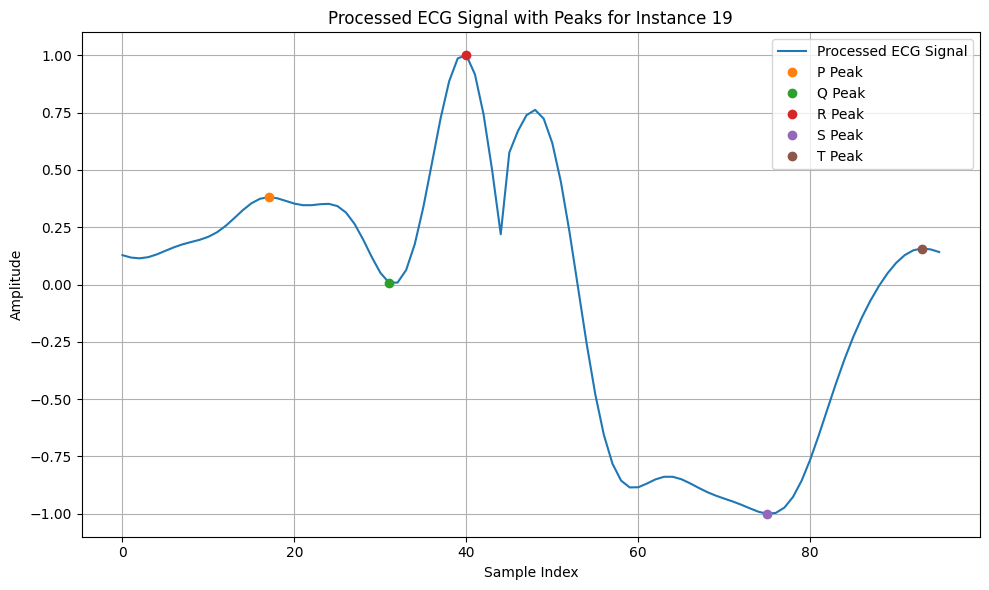

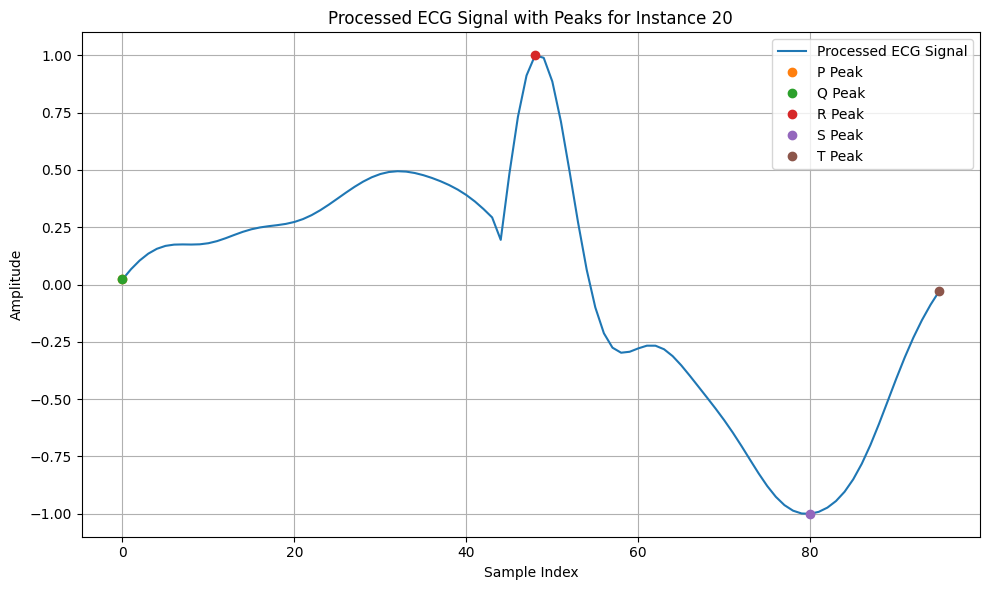

In [234]:
# Function to plot the processed ECG signal with highlighted peaks
def plot_processed_ecg_with_peaks(signal, peaks, title='Processed ECG Signal with Peaks'):
    plt.figure(figsize=(10, 6))
    plt.plot(signal, label='Processed ECG Signal')

    # Highlight the peaks
    for peak_name, peak_idx in peaks.items():
        if peak_idx is not None:
            plt.plot(peak_idx, signal[peak_idx], 'o', label=f'{peak_name} Peak')

    plt.title(title)
    plt.xlabel('Sample Index')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Extract QRS features and detect peaks
qrs_features, peaks = extract_qrs_features(aligned_signal, fs)

# Plot the processed signal with highlighted peaks
plot_processed_ecg_with_peaks(aligned_signal, peaks, title=f'Processed ECG Signal with Peaks for Instance {i+1}')


# Preprocess the first 20 instances
for i in range(20):
    signal = processed_signals[i]

    # Detect and highlight peaks

    # Extract QRS features and detect peaks
    qrs_features, peaks = extract_qrs_features(signal, fs)

    # Plot the processed signal with highlighted peaks
    plot_processed_ecg_with_peaks(signal, peaks, title=f'Processed ECG Signal with Peaks for Instance {i+1}')


**2.2 Statistical Features**

In [235]:
def extract_statistical_features(signal):
    mean = np.mean(signal)
    std_dev = np.std(signal)
    skewness = np.mean((signal - mean)**3) / std_dev**3
    kurtosis = np.mean((signal - mean)**4) / std_dev**4 - 3
    return [mean, std_dev, skewness, kurtosis]


**2.3 Frequency-Domain Features**

In [236]:
def extract_frequency_features(signal, fs=500):
    freqs = np.fft.fftfreq(len(signal), 1/fs)
    fft_spectrum = np.fft.fft(signal)
    power_spectrum = np.abs(fft_spectrum)**2
    return [np.mean(power_spectrum), np.var(power_spectrum)]


**2.4 Wavelet Transform Features**

In [237]:
def extract_wavelet_features(signal, wavelet='db4', level=3):
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    return [np.sum(np.abs(coeff)**2) for coeff in coeffs]


**2.5 STFT Features**

In [238]:
def extract_stft_features(signal, fs=500, nperseg=32):
    _, _, Zxx = stft(signal, fs=fs, nperseg=nperseg)
    return [np.mean(np.abs(Zxx)), np.var(np.abs(Zxx))]


**2.6 Nonlinear Features**

**Entropy:**

In [239]:
from scipy.stats import entropy

# Entropy-based features
def calculate_entropy(signal):
    histogram, _ = np.histogram(signal, bins=10, density=True)
    return entropy(histogram)



**Fractal Dimension**

In [240]:
def calculate_fractal_dimension(signal):
    N = len(signal)
    scales = np.arange(2, int(N/2))
    rs = []
    for s in scales:
        rms = np.sqrt(np.mean(signal[:N//s]**2))
        rs.append(rms)
    return np.polyfit(np.log(scales), np.log(rs), 1)[0]


# **Feature Extraction Workflow**

In [241]:

# Extract all features
features_list = []

for i in range(len(processed_signals)):
    signal = processed_signals[i]

    # Statistical features
    stats_features = extract_statistical_features(signal)

    # Frequency domain features
    freq_features = extract_frequency_features(signal, fs)

    # Wavelet features
    wavelet_features = extract_wavelet_features(signal)

    # Entropy-based features
    shannon_entropy = calculate_entropy(signal)
    fractal_feature = calculate_fractal_dimension(signal)

    # STFT features
    stft_features = extract_stft_features(signal, fs)

    # QRS complex features
    qrs_features ,peaks = extract_qrs_features(signal, fs)

    # Combine all features into one list
    combined_features = (
        stats_features +
        freq_features +
        wavelet_features +
        [shannon_entropy, fractal_feature] +
        stft_features +
        qrs_features +
        [labels[i]]  # Add the label to the features
    )

    features_list.append(combined_features)

# Create a DataFrame with the extracted features
columns = [
    'Mean', 'StdDev', 'Skewness', 'Kurtosis',
    'MeanPower', 'VarPower',
    'WaveletCoeff1', 'WaveletCoeff2', 'WaveletCoeff3', 'WaveletCoeff4',
    'Shannon_Entropy',  'Fractal_Dimension',
    'STFT_Mean', 'STFT_Var',
    'Q_Amplitude', 'R_Amplitude', 'S_Amplitude', 'T_Amplitude', 'P_Amplitude',
    'PQ_Interval', 'QR_Interval', 'RS_Interval', 'ST_Interval', 'TP_Interval',
    'Label'  # Column for labels
]

features_df = pd.DataFrame(features_list, columns=columns)

# Display the first few rows of the new DataFrame with all features and labels
print(features_df.head())

       Mean    StdDev  Skewness  Kurtosis  MeanPower      VarPower  \
0  0.034590  0.565972 -0.491072 -1.062349  30.865962  27962.017499   
1  0.096175  0.596845 -0.358535 -1.137032  35.085495  16463.099597   
2  0.153972  0.577862 -0.708883 -0.900414  34.332680  28726.439407   
3  0.022244  0.548497 -0.429321 -0.680070  28.928992  21909.523056   
4  0.148217  0.532225 -0.761092 -0.522588  29.302263  10865.564896   

   WaveletCoeff1  WaveletCoeff2  WaveletCoeff3  WaveletCoeff4  ...  \
0      34.016222       0.471870       0.064234       0.006437  ...   
1      57.129622       1.345428       0.846739       0.023173  ...   
2      44.678744       0.552442       0.076262       0.008343  ...   
3      29.235115       0.372159       0.140488       0.006400  ...   
4      40.304659       0.555751       0.038144       0.025135  ...   

   R_Amplitude  S_Amplitude  T_Amplitude  P_Amplitude  PQ_Interval  \
0          1.0         -1.0     0.137127     0.197563          0.0   
1          1.0    

# **3. Model Training**

**3.1 Model Initialization and Training**

In [243]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Load and preprocess your data (assuming features_df is your DataFrame)

# Separate features and labels
X = features_df.drop('Label', axis=1)
y = features_df['Label']

# Check for NaN values in the DataFrame and drop rows with NaN values
if X.isna().any().any():
    nan_columns = X.columns[X.isna().any()].tolist()
    # Drop rows with NaN values
    X = X.dropna()
    y = y[X.index]  # Align labels with the cleaned feature set

# Ensure labels are aligned with the filtered feature set
X, y = X.reset_index(drop=True), y.reset_index(drop=True)

# Standardize the feature values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Initialize models
models = {
    'Logistic Regression': LogisticRegression(max_iter=200),
    'Support Vector Machine': SVC(probability=True),
    'Random Forest': RandomForestClassifier(n_estimators=100),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100)
}

# Train and evaluate models
for name, model in models.items():
    try:
        model.fit(X_scaled, y)
        y_pred = model.predict(X_scaled)

        print(f"Model: {name}")
        print(f"Accuracy: {accuracy_score(y, y_pred):.2f}")
        print("Classification Report:")
        print(classification_report(y, y_pred))
        print("Confusion Matrix:")
        print(confusion_matrix(y, y_pred))
        print("\n")
    except Exception as e:
        print(f"An error occurred while training {name}: {e}")


Model: Logistic Regression
Accuracy: 0.94
Classification Report:
              precision    recall  f1-score   support

        -1.0       0.93      0.86      0.89        29
         1.0       0.94      0.97      0.96        66

    accuracy                           0.94        95
   macro avg       0.93      0.92      0.92        95
weighted avg       0.94      0.94      0.94        95

Confusion Matrix:
[[25  4]
 [ 2 64]]


Model: Support Vector Machine
Accuracy: 0.95
Classification Report:
              precision    recall  f1-score   support

        -1.0       0.96      0.86      0.91        29
         1.0       0.94      0.98      0.96        66

    accuracy                           0.95        95
   macro avg       0.95      0.92      0.94        95
weighted avg       0.95      0.95      0.95        95

Confusion Matrix:
[[25  4]
 [ 1 65]]


Model: Random Forest
Accuracy: 1.00
Classification Report:
              precision    recall  f1-score   support

        -1.0       1.

# **4. Model Testing (CHANGE THE TEST_FILE_PATH)**

**Model Testing and Performance Reporting**

In [242]:
import pandas as pd
import numpy as np
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
# Load the test data
test_file_path = 'ECG200_TEST.txt'  # UPDATE THIS WITH THE TEST FILE NAME
test_data = pd.read_csv(test_file_path, delim_whitespace=True, header=None)
test_labels = test_data.iloc[:, 0].values  # Extract labels
test_signals = test_data.iloc[:, 1:].values  # Extract ECG signals

# Apply preprocessing to the test signals
test_processed_signals = []
for signal in test_signals:
    # Remove baseline drift
    signal_processed = remove_baseline_drift(signal)
    # Apply low-pass filter
    signal_processed = low_pass_filter(signal_processed, cutoff_freq=40, fs=500)
    # Apply notch filter
    signal_processed = notch_filter(signal_processed, fs=500)
    # Normalize the signal
    normalized_signal = normalize_signal(signal_processed)

# Step 5: Detect R peak
    r_peak_index = detect_r_peak(normalized_signal)

    # Step 6: Align the signal to the R peak if detected
    if r_peak_index is not None:
        aligned_signal = align_to_r_peak(normalized_signal, r_peak_index)
    else:
        # If no R peak is detected, use the normalized signal as is
        aligned_signal = normalized_signal

    test_processed_signals.append(aligned_signal)



# Convert processed signals to a numpy array
test_processed_signals = np.array(test_processed_signals)

# Extract all features for the test set
test_features_list = []

for i in range(len(test_processed_signals)):
    signal = test_processed_signals[i]

    # Statistical features
    stats_features = extract_statistical_features(signal)

    # Frequency domain features
    freq_features = extract_frequency_features(signal, fs=500)

    # Wavelet features
    wavelet_features = extract_wavelet_features(signal)

    # Entropy-based features
    shannon_entropy = calculate_entropy(signal)
    fractal_feature = calculate_fractal_dimension(signal)

    # STFT features
    stft_features = extract_stft_features(signal, fs=500)

    # QRS complex features
    qrs_features , peaks = extract_qrs_features(signal, fs=500)

    # Combine all features into one list
    combined_features = (
        stats_features +
        freq_features +
        wavelet_features +
        [shannon_entropy, fractal_feature] +
        stft_features +
        qrs_features
    )

    test_features_list.append(combined_features)

# Create a DataFrame with the extracted features
test_columns = [
    'Mean', 'StdDev', 'Skewness', 'Kurtosis',
    'MeanPower', 'VarPower',
    'WaveletCoeff1', 'WaveletCoeff2', 'WaveletCoeff3', 'WaveletCoeff4',
    'Shannon_Entropy',  'Fractal_Dimension',
    'STFT_Mean', 'STFT_Var',
    'Q_Amplitude', 'R_Amplitude', 'S_Amplitude', 'T_Amplitude', 'P_Amplitude',
    'PQ_Interval', 'QR_Interval', 'RS_Interval', 'ST_Interval', 'TP_Interval'
]

test_features_df = pd.DataFrame(test_features_list, columns=test_columns)
test_features_df['Label'] = test_labels

# Handle any NaNs in the test features
if test_features_df.isna().any().any():
    print(f"NaNs found in test features. Dropping rows with NaNs.")
    test_features_df = test_features_df.dropna()

# Separate features and labels for standardization and testing
X_test = test_features_df.drop('Label', axis=1)
y_test = test_features_df['Label']

# Standardize the test features using the scaler fitted on the training data
X_test_scaled = scaler.transform(X_test)

# Display the shape and first few rows of the test feature DataFrame
print("Processed test features shape:", X_test_scaled.shape)
print("First few rows of the test feature DataFrame:")
print(test_features_df.head())




# Assuming models were trained
best_model_name = None
best_accuracy = 0
model_accuracies = {}

for name, model in models.items():
    y_pred = model.predict(X_test_scaled)

    accuracy = accuracy_score(y_test, y_pred)
    print(f"Model: {name}")
    print(f"Accuracy: {accuracy:.2f}")
    print("Predicted Values:")
    print(y_pred)


    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix for {name}")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    if y_pred_proba is not None:
        # Calculate and print ROC AUC score
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        print(f"ROC AUC: {roc_auc:.2f}")

    print("\n")

    # Track the best model based on accuracy
    model_accuracies[name] = accuracy
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model_name = name

# Print the best model based on accuracy
print(f"The best model is {best_model_name} with an accuracy of {best_accuracy:.2f}")
